# PARAMETER IDENTIFICATION NOTEBOOK

In this notebook we leverage the pretrained surrogate models to identify the generating transmissivity fiels.\
We start from noisy signals. The noise is an additive white noise, manually added to the data to emulate experimental data. 

##### Importing necessary libraries

In [2]:
# Standard library imports
import sys

import os
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['KERAS_BACKEND'] = 'tensorflow'

# Third-party library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import arviz as az
import timeit

import scipy.stats as stats
from keras.models import Sequential
from keras.layers import Dense, Concatenate
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.models import load_model

#Try with TinyDA
import tinyDA as tda
from scipy.stats import multivariate_normal
from scipy.stats import uniform


# Local module imports
sys.path.append('./src/SurrogateModeling')
sys.path.append('./src/InverseProblems')
sys.path.append('./src/utils')
from utils import * 
from plotting import *
from random_process import *


2024-07-28 17:41:42.572481: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Ray module not found. Multiprocessing features are not available


#### Decide sample to use for experimental data

In [3]:
sample = 16 # Which sample of the training set do wou want to take as experimental input?
OUTPUT_FILENAME = "./samples/sample_coarse_"+str(sample)

#### Set Bayesian Identification Parameters

In [4]:
# Noise Configuration
noise = 0.001

#### Load Surrogate Models

In [5]:
# Extract test data for visualization or further processing
n_eig = 64
X_values = np.loadtxt('./data/X_test_64000.csv', delimiter = ',')
y_values = np.loadtxt('./data/y_test_64000.csv',delimiter = ',')

In [6]:
model_c = Sequential()

# Add layers to the model
model_c.add(Dense(128, input_shape=(64,), activation='gelu'))
model_c.add(Dense(64, activation='gelu'))
model_c.add(Dense(25, activation='exponential'))

model_c = load_model('./models3/model_LF_16000_2.keras')

/Users/lucacaroselli/miniconda3/envs/fenics/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
def model_lf(input):
    return np.array(model_c(input.reshape(1,64))).reshape(25)

In [8]:
model_f = Sequential()

model_f.add(Dense(256, input_shape=(89,), activation='gelu'))
model_f.add(Dense(128, activation='gelu'))
model_f.add(Dense(64, activation='gelu'))
model_f.add(Dense(25, activation='exponential'))

model_f = load_model('./models3/model_HF_16000_1.keras')

In [9]:
def model_hf (input):
    input = input.reshape(1,64)
    input_fine = np.hstack((input, model_c(input) )).reshape(1,89)
    return np.array(model_f(input_fine)).reshape(25)

### Define Prior, likelyhood and proposal

In [10]:
# Select a true sample for testing
x_true, y_true = X_values[sample], y_values[sample]
# Generate observed data by adding Gaussian noise to the true data
y_observed = y_true + np.random.normal(scale=noise,size=y_true.shape[0])

# Define the prior distribution for the input parameters
x_distribution = stats.multivariate_normal(mean = np.zeros(n_eig), cov = np.eye(n_eig))

# set the likelihood
cov_likelihood = noise * np.eye(25)
y_distribution_coarse = tda.AdaptiveGaussianLogLike(y_observed, cov_likelihood)  
y_distribution_fine = tda.GaussianLogLike(y_observed, cov_likelihood)  

In [35]:
x_true

array([ 1.1537516 ,  1.59930096,  1.0712466 ,  0.16285143, -1.77693013,
        1.13429878, -0.93495814,  2.69019167,  0.62724265,  2.43673345,
       -0.56867574, -0.14274359, -2.2278197 , -0.75301225, -1.62102912,
        1.00922652,  1.91294232, -0.85850774, -2.31511961,  2.52755889,
        0.09154126, -0.29053499, -0.53602897,  0.34754535, -0.01173919,
        1.17243121, -1.22188369, -0.96913818, -0.39950806,  1.01188892,
       -1.20621682, -0.87489908,  0.57811353, -0.52530346, -1.09333604,
        1.10048611,  0.91836686,  1.14180672,  0.48037021,  1.52078407,
        1.50176772,  0.74254826,  0.04931592, -0.34914246,  1.8694958 ,
        1.63233869, -1.17102144,  1.14337158,  0.92133669,  0.30800992,
       -0.87071644, -0.604474  ,  0.22870254,  0.15959755,  0.5696756 ,
       -0.17067527,  0.27926433, -1.32688715,  0.87618644,  0.16703566,
       -0.26100612,  0.29748849,  1.39345466, -0.99058778])

#### Perform least square optimization for each starting point

In [25]:
# Initialize a list to hold the optimized parameters for each start point
initial_guesses = []

# Display the true parameters for reference
print("Real Params: ", x_true)

bounds = (-3*np.ones(n_eig), 3*np.ones(n_eig))

# Iterate over each parameter start point to perform optimizatio
# Perform least squares optimization given the observed data, forward model,
# start point, and parameter bounds
optimized_params, covariance_matrix = least_squares_optimization(
        y_observed=y_observed, 
        forward_model=model_lf , 
        start_point=np.zeros(n_eig), 
        bounds=bounds,
        l2_coeff = 0#1e-6
    )

# Append the optimized parameters to the list of initial guesses
initial_guesses.append(optimized_params)

# Print the optimized parameters for this iteration
print(f"Optimized Params : {optimized_params}")


Real Params:  [ 1.1537516   1.59930096  1.0712466   0.16285143 -1.77693013  1.13429878
 -0.93495814  2.69019167  0.62724265  2.43673345 -0.56867574 -0.14274359
 -2.2278197  -0.75301225 -1.62102912  1.00922652  1.91294232 -0.85850774
 -2.31511961  2.52755889  0.09154126 -0.29053499 -0.53602897  0.34754535
 -0.01173919  1.17243121 -1.22188369 -0.96913818 -0.39950806  1.01188892
 -1.20621682 -0.87489908  0.57811353 -0.52530346 -1.09333604  1.10048611
  0.91836686  1.14180672  0.48037021  1.52078407  1.50176772  0.74254826
  0.04931592 -0.34914246  1.8694958   1.63233869 -1.17102144  1.14337158
  0.92133669  0.30800992 -0.87071644 -0.604474    0.22870254  0.15959755
  0.5696756  -0.17067527  0.27926433 -1.32688715  0.87618644  0.16703566
 -0.26100612  0.29748849  1.39345466 -0.99058778]
Optimized Params : [ 0.39736546  0.87996631  0.98753333  0.0441518  -2.1378683   0.91206262
 -1.35923488  1.41795564  1.40087382  1.49527747  0.16692484 -0.11250617
 -0.8986329  -0.32804618 -0.29672664 -0.5

#### Do Metropolis Hastings Sampling

Set the parameters for the algorithm 

In [21]:
scaling = 0.1
n_iter =  28000 #55000
burnin = 3000 #5000
thin = 25
sub_sampling = 2

In [22]:
#cov = np.diag(np.linspace(1,5,n_eig))
cov = np.eye(n_eig)

In [23]:
# initialise the LinkFactory
my_posterior_coarse = tda.Posterior(x_distribution, y_distribution_coarse, model_lf)
my_posterior_fine  = tda.Posterior(x_distribution, y_distribution_fine, model_hf)
my_posteriors = [ my_posterior_coarse, my_posterior_fine ]
# random walk Metropolis
#my_proposal = tda.GaussianRandomWalk(C=covariance_matrix*1e-19, scaling= scaling)
my_proposal = tda.CrankNicolson(scaling=scaling, adaptive=False, gamma = 1.01, period=100)
#my_proposal = tda.AdaptiveMetropolis(C0=np.eye(n_eig), sd = 0.2)


In [24]:
# Initialize a list to hold the Markov chain samples for each initial guess
samples_mh = []
ESS_values = []

# Iterate over each initial guess to set up and run the Markov chain sampler
start_0 = timeit.default_timer() 
for index, initial_guess in enumerate(initial_guesses):
    samples = tda.sample(my_posteriors, my_proposal, iterations=n_iter, n_chains=1, initial_parameters=np.zeros(64), adaptive_error_model='state-independent')
    idata = tda.to_inference_data(samples, level='fine')
    # Remove the burnin and sub-sample
    idata = idata.sel(draw=slice(burnin, None, thin), groups="posterior")
    # Append the samples to the list
    samples_mh.append(idata)
    ess = az.ess(idata)
    # Compute and print the Effective Sample Size (ESS) of the first set of samples
    print("Effective Sample Size: ", ess,"\n\n\n")
end_0 = timeit.default_timer() 

# Computing diagnostics and collecting results
#print("\nRhat: ", az.rhat(az.concat(samples_mh, dim = 'chain')))

#print('Mean ESS:' , np.mean(ESS_values, axis = 0))
#print('Time/ESS MDA',(end_0-start_0)/(5*np.mean(ESS_values, axis = 0)) )


Sampling chain 1/1


Running chain, α_c = 0.440, α_f = 0.35: 100%|██████████| 28000/28000 [02:51<00:00, 163.64it/s]
/Users/lucacaroselli/miniconda3/envs/fenics/lib/python3.11/site-packages/arviz/data/inference_data.py:157: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Effective Sample Size:  <xarray.Dataset> Size: 512B
Dimensions:  ()
Data variables: (12/64)
    x0       float64 8B 35.62
    x1       float64 8B 43.81
    x2       float64 8B 57.81
    x3       float64 8B 41.91
    x4       float64 8B 26.46
    x5       float64 8B 28.45
    ...       ...
    x58      float64 8B 10.17
    x59      float64 8B 8.924
    x60      float64 8B 27.24
    x61      float64 8B 14.87
    x62      float64 8B 11.77
    x63      float64 8B 28.77 





Let's look at the trace plot of one chain

# Diagnostics 

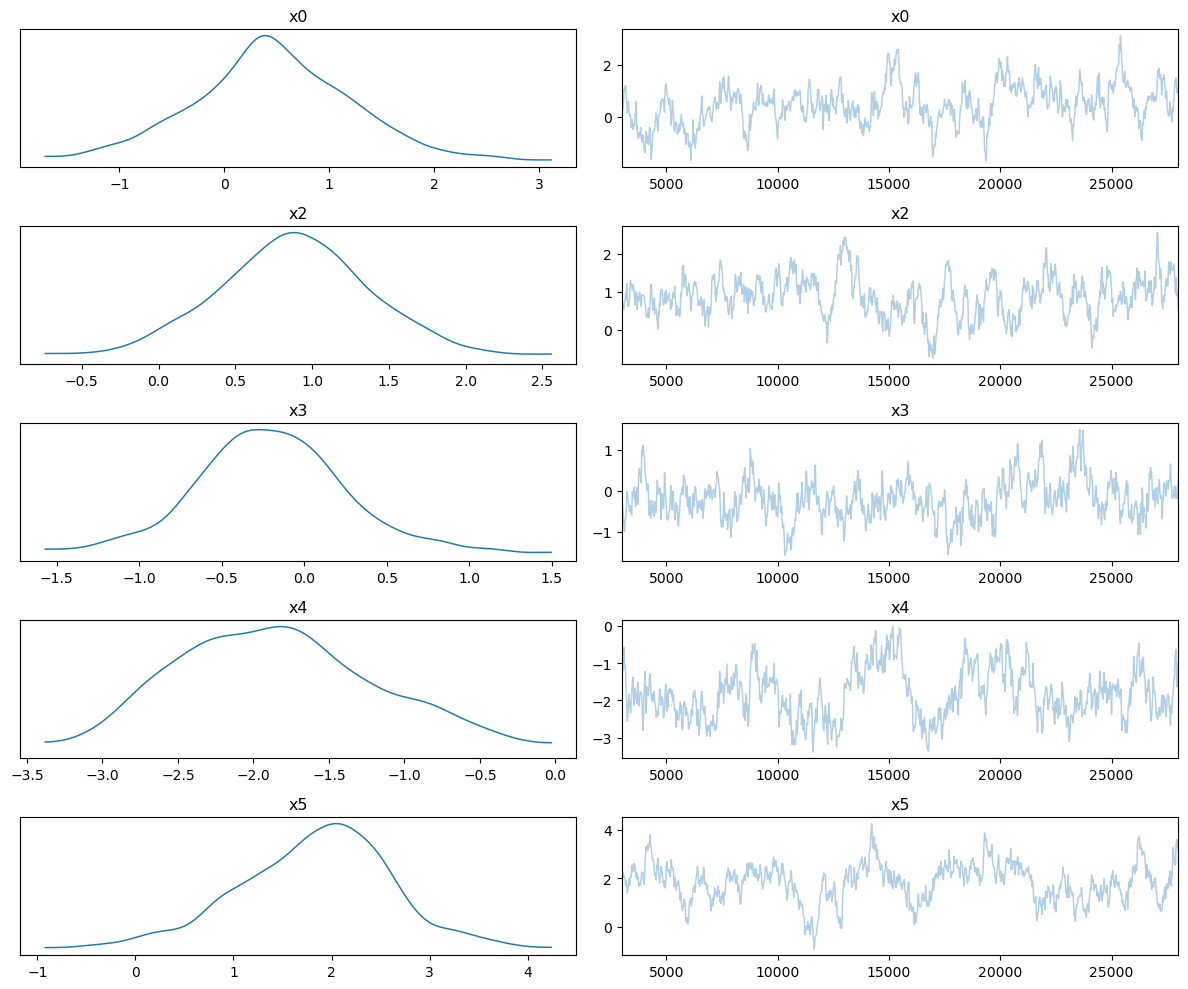

In [25]:
# Plot trace of the first set of samples
az.plot_trace(idata, var_names=['x0', 'x2', 'x3','x4','x5'])
plt.tight_layout()
plt.show()


Let's compare the prediction of the mean parameter combination and the experimental signal

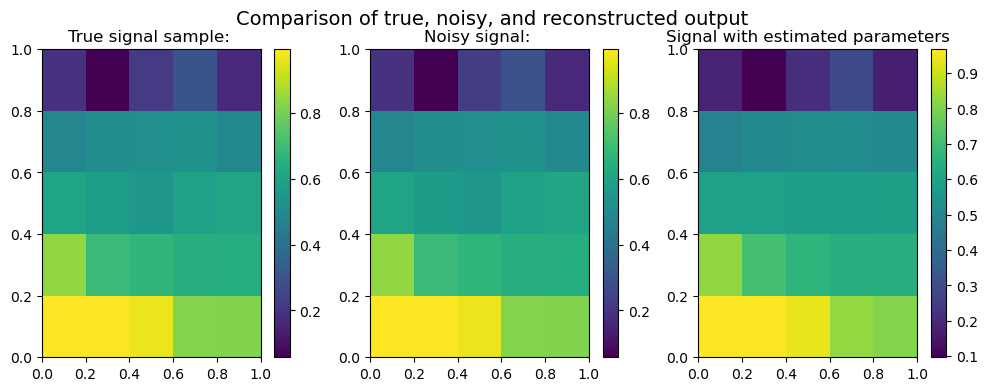

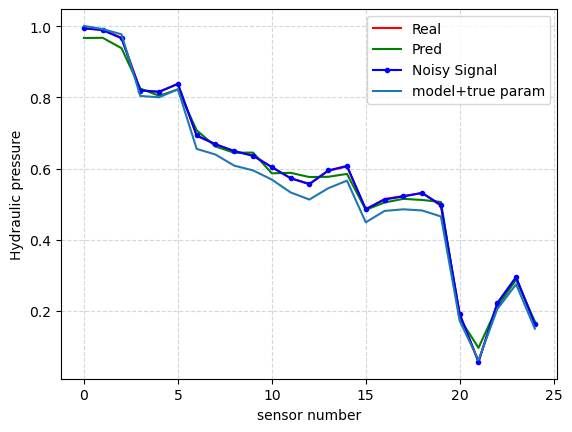

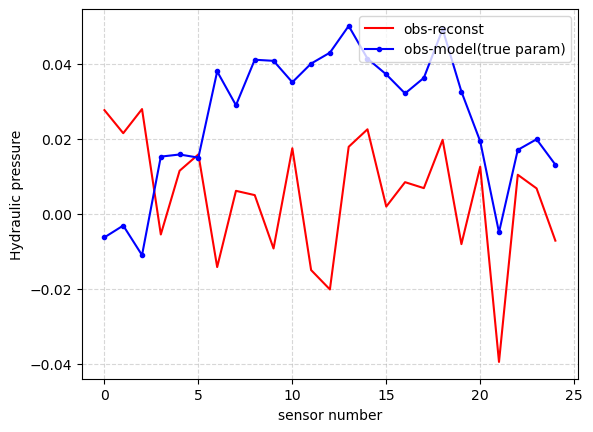

In [35]:
# Plotting and data collection
data = tda.get_samples(samples)['chain_0'][burnin:n_iter:thin, :]
plot_results( y_true, y_observed, model_hf, data, n_eig,x_true)

Finally, let's look at the parameters distribution

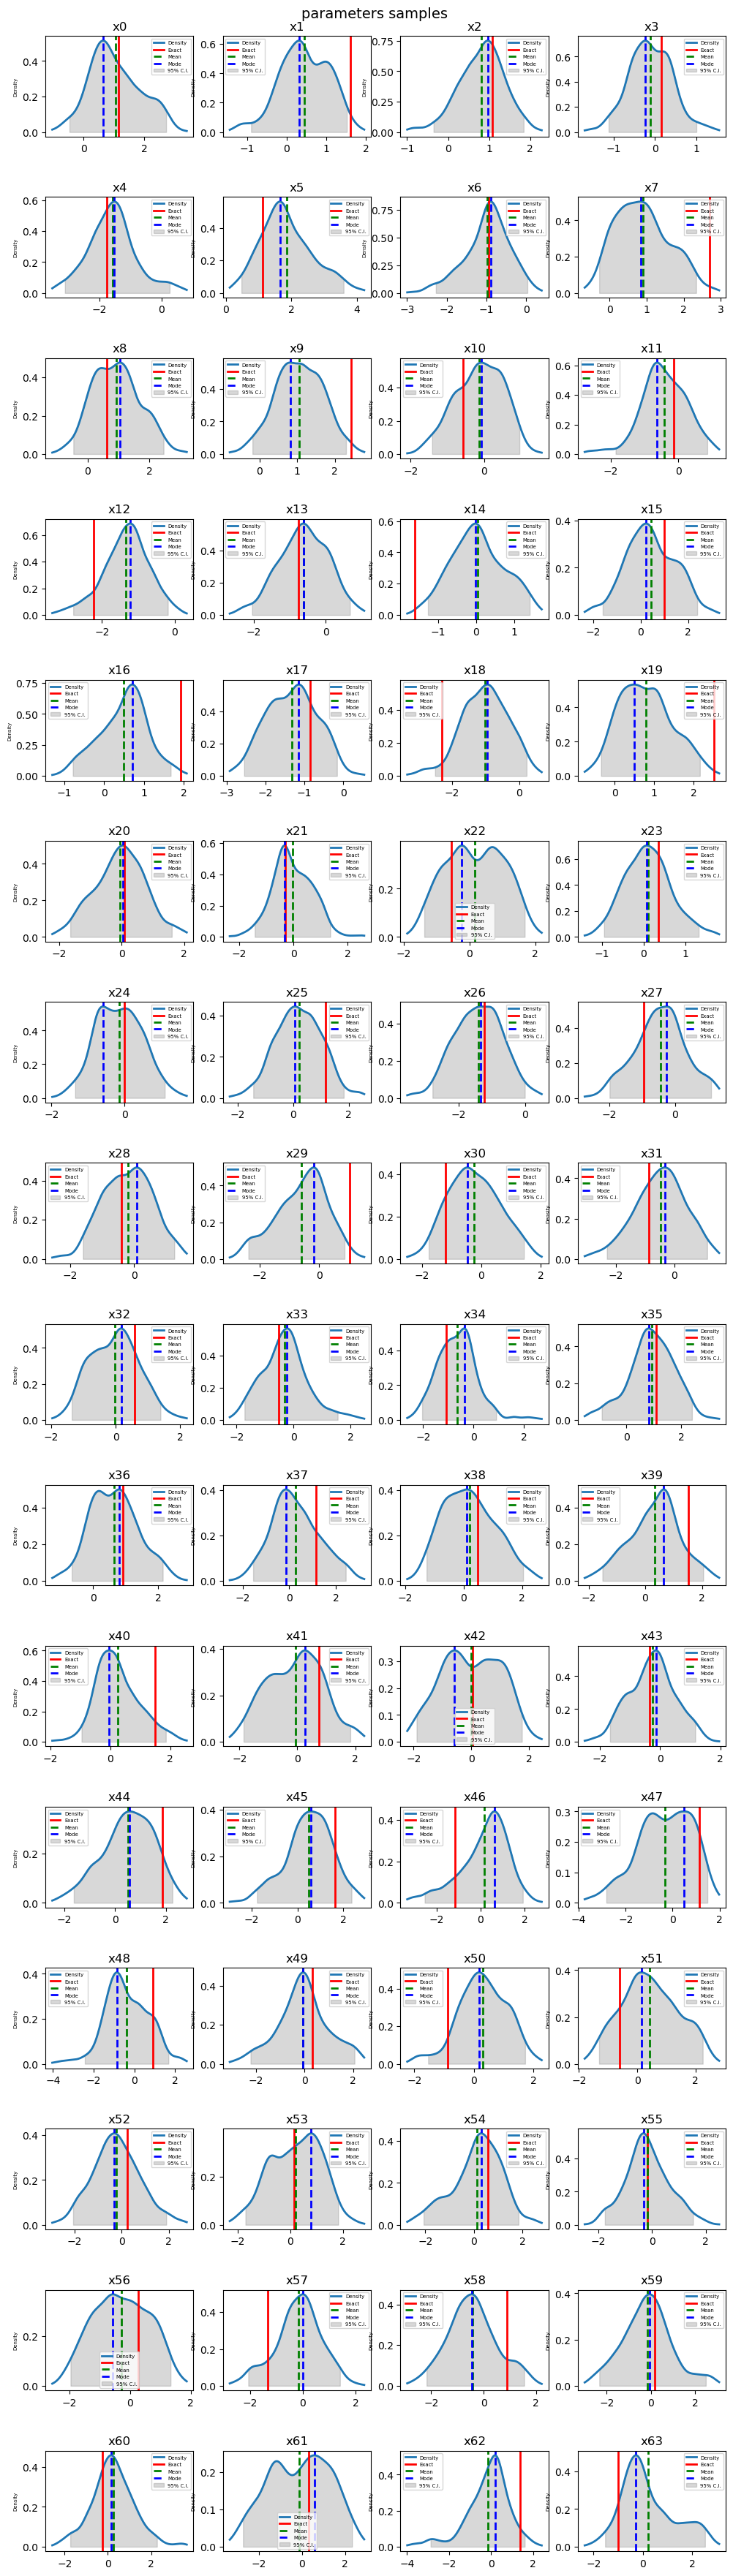

In [ ]:
keys = ['x'+ str(i) for i in range(64)]
plot_parameter_distributions(data, x_true, keys, n_eig) 

### Reconstructed field 

<Figure size 1000x400 with 0 Axes>

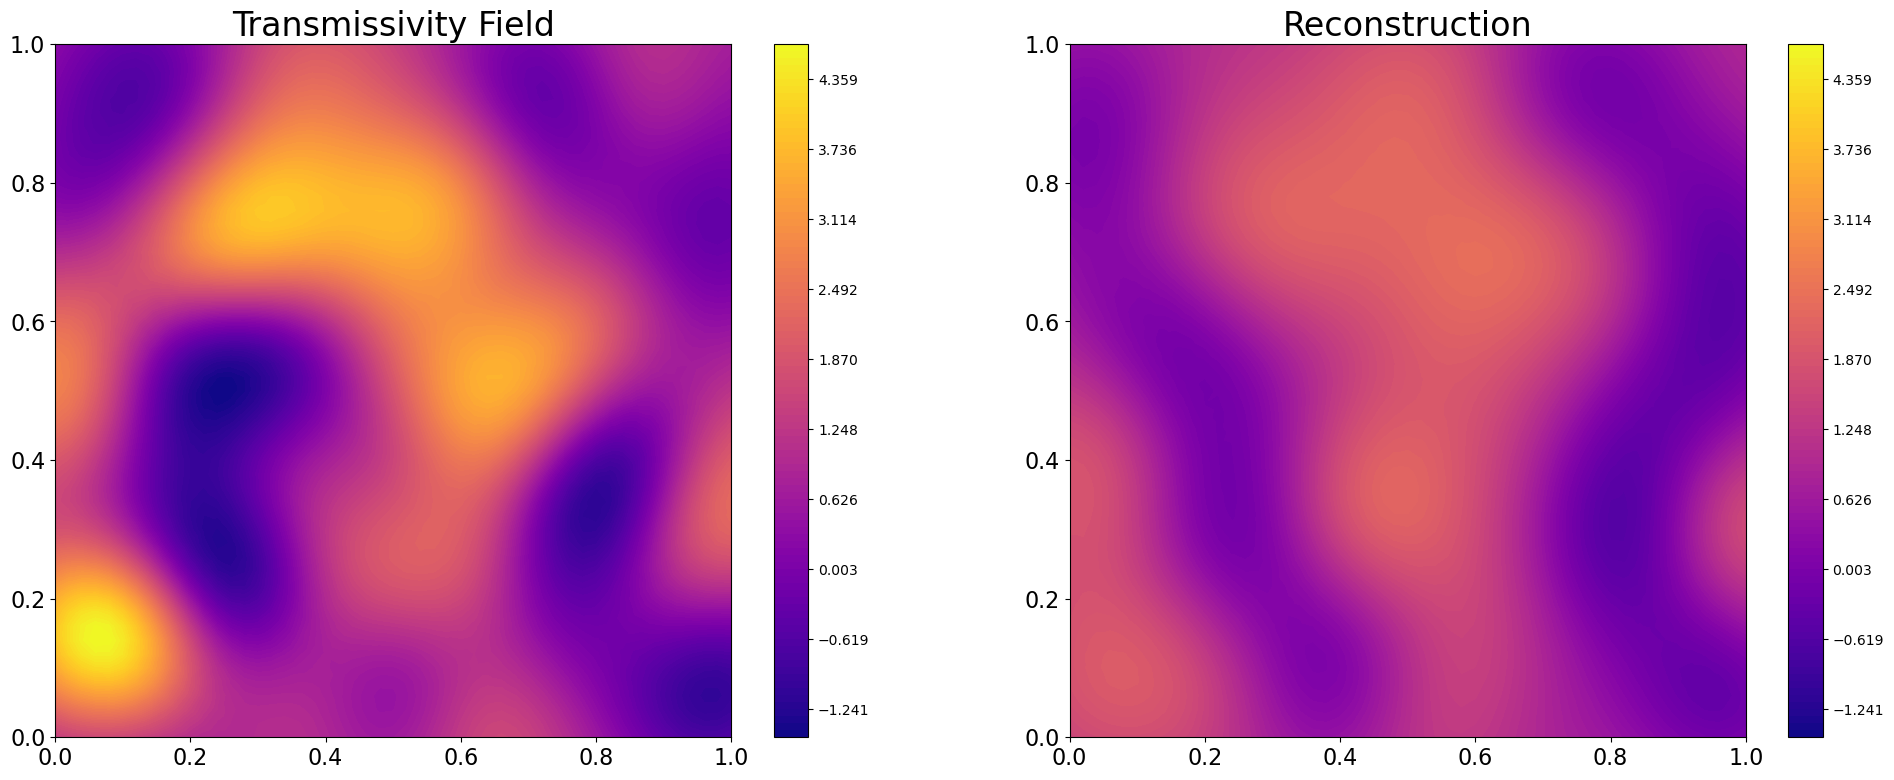

In [36]:
plot_fields(x_true=x_true, x_estimated=data.mean(axis=0),n_eig=n_eig, lognormal=False)

# DIFFERENT PARAMETERS 

### Lower likelyhood

In [32]:
noise = 0.001
scaling = 0.04
n_iter =  30000 #55000
burnin = 5000 #5000
thin = 20
sub_sampling = 1


y_observed = y_true + np.random.normal(scale=noise,size=y_true.shape[0])

# LIKELYHOOD
cov_likelihood = noise * np.eye(25)
y_distribution_coarse = tda.AdaptiveGaussianLogLike(y_observed, cov_likelihood*0.1)
y_distribution_fine  = tda.GaussianLogLike(y_observed, cov_likelihood*0.1)

# initialise the LinkFactory
my_posterior_coarse = tda.Posterior(x_distribution, y_distribution_coarse, model_lf)
my_posterior_fine = tda.Posterior(x_distribution, y_distribution_fine, model_hf)
my_posteriors = [my_posterior_coarse, my_posterior_fine]
my_proposal = tda.CrankNicolson(scaling=scaling, adaptive=False, gamma = 1.01, period=100)

# RUN THE MCMC
samples = tda.sample(my_posteriors, my_proposal, iterations=n_iter, n_chains=1, initial_parameters=np.zeros(64), subsampling_rate= sub_sampling, adaptive_error_model='state-independent')
idata = tda.to_inference_data(samples, level='fine')
# Remove the burnin and sub-sample
idata = idata.sel(draw=slice(burnin, None, thin), groups="posterior")
ess = az.ess(idata)
# Compute and print the Effective Sample Size (ESS) of the first set of samples
print("Effective Sample Size: ", ess,"\n\n\n")




Sampling chain 1/1


Running chain, α_c = 0.530, α_f = 0.38: 100%|██████████| 30000/30000 [03:00<00:00, 165.99it/s]
/Users/lucacaroselli/miniconda3/envs/fenics/lib/python3.11/site-packages/arviz/data/inference_data.py:157: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Effective Sample Size:  <xarray.Dataset> Size: 512B
Dimensions:  ()
Data variables: (12/64)
    x0       float64 8B 13.89
    x1       float64 8B 7.789
    x2       float64 8B 6.855
    x3       float64 8B 9.299
    x4       float64 8B 11.66
    x5       float64 8B 8.791
    ...       ...
    x58      float64 8B 8.272
    x59      float64 8B 5.299
    x60      float64 8B 14.7
    x61      float64 8B 10.5
    x62      float64 8B 9.137
    x63      float64 8B 7.409 





<Figure size 1000x400 with 0 Axes>

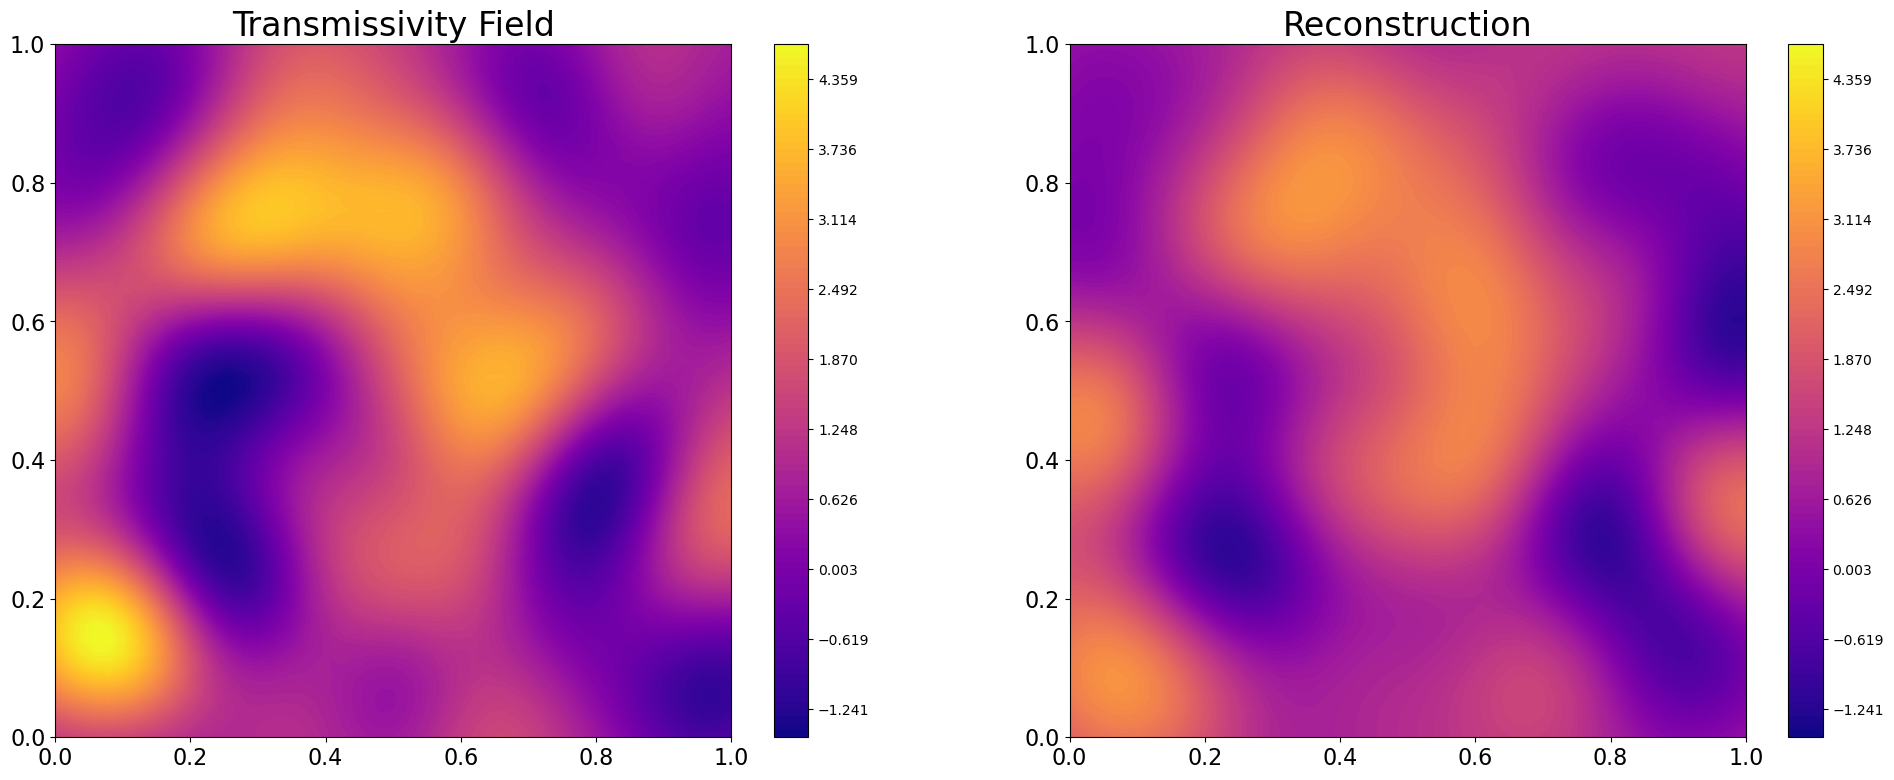

In [33]:
data = tda.get_samples(samples)['chain_0'][burnin:n_iter:thin, :]
plot_fields(x_true=x_true, x_estimated=data.mean(axis=0),n_eig=n_eig, lognormal=False) 

### Higher Noise 

In [23]:
noise = 0.01
scaling = 0.05
n_iter =  30000 #55000
burnin = 5000 #5000
thin = 20
sub_sampling = 2


y_observed = y_true + np.random.normal(scale=noise,size=y_true.shape[0])

# LIKELYHOOD
cov_likelihood = noise**2 * np.eye(25)
y_distribution_coarse = tda.AdaptiveGaussianLogLike(y_observed, cov_likelihood)
y_distribution_fine  = tda.GaussianLogLike(y_observed, cov_likelihood)

# initialise the LinkFactory
my_posterior_coarse = tda.Posterior(x_distribution, y_distribution_coarse, model_lf)
my_posterior_fine = tda.Posterior(x_distribution, y_distribution_fine, model_hf)
my_posteriors = [my_posterior_coarse, my_posterior_fine]
my_proposal = tda.CrankNicolson(scaling=scaling, adaptive=False, gamma = 1.01, period=100)

# RUN THE MCMC
samples = tda.sample(my_posteriors, my_proposal, iterations=n_iter, n_chains=1, initial_parameters=np.zeros(64), subsampling_rate= sub_sampling, adaptive_error_model='state-independent')
idata = tda.to_inference_data(samples, level='fine')
# Remove the burnin and sub-sample
idata = idata.sel(draw=slice(burnin, None, thin), groups="posterior")
ess = az.ess(idata)
# Compute and print the Effective Sample Size (ESS) of the first set of samples
print("Effective Sample Size: ", ess,"\n\n\n")


Sampling chain 1/1


Running chain, α_c = 0.395, α_f = 0.15: 100%|██████████| 30000/30000 [05:08<00:00, 97.17it/s] 
/Users/lucacaroselli/miniconda3/envs/fenics/lib/python3.11/site-packages/arviz/data/inference_data.py:157: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Effective Sample Size:  <xarray.Dataset> Size: 512B
Dimensions:  ()
Data variables: (12/64)
    x0       float64 8B 7.534
    x1       float64 8B 1.587
    x2       float64 8B 2.069
    x3       float64 8B 13.35
    x4       float64 8B 12.99
    x5       float64 8B 4.357
    ...       ...
    x58      float64 8B 9.665
    x59      float64 8B 17.84
    x60      float64 8B 5.346
    x61      float64 8B 3.31
    x62      float64 8B 7.117
    x63      float64 8B 1.411 





In [24]:
e = [ess.data_vars['x'+str(i)].values for i in range(64)]
np.mean(e)

9.69524060972925

<Figure size 1000x400 with 0 Axes>

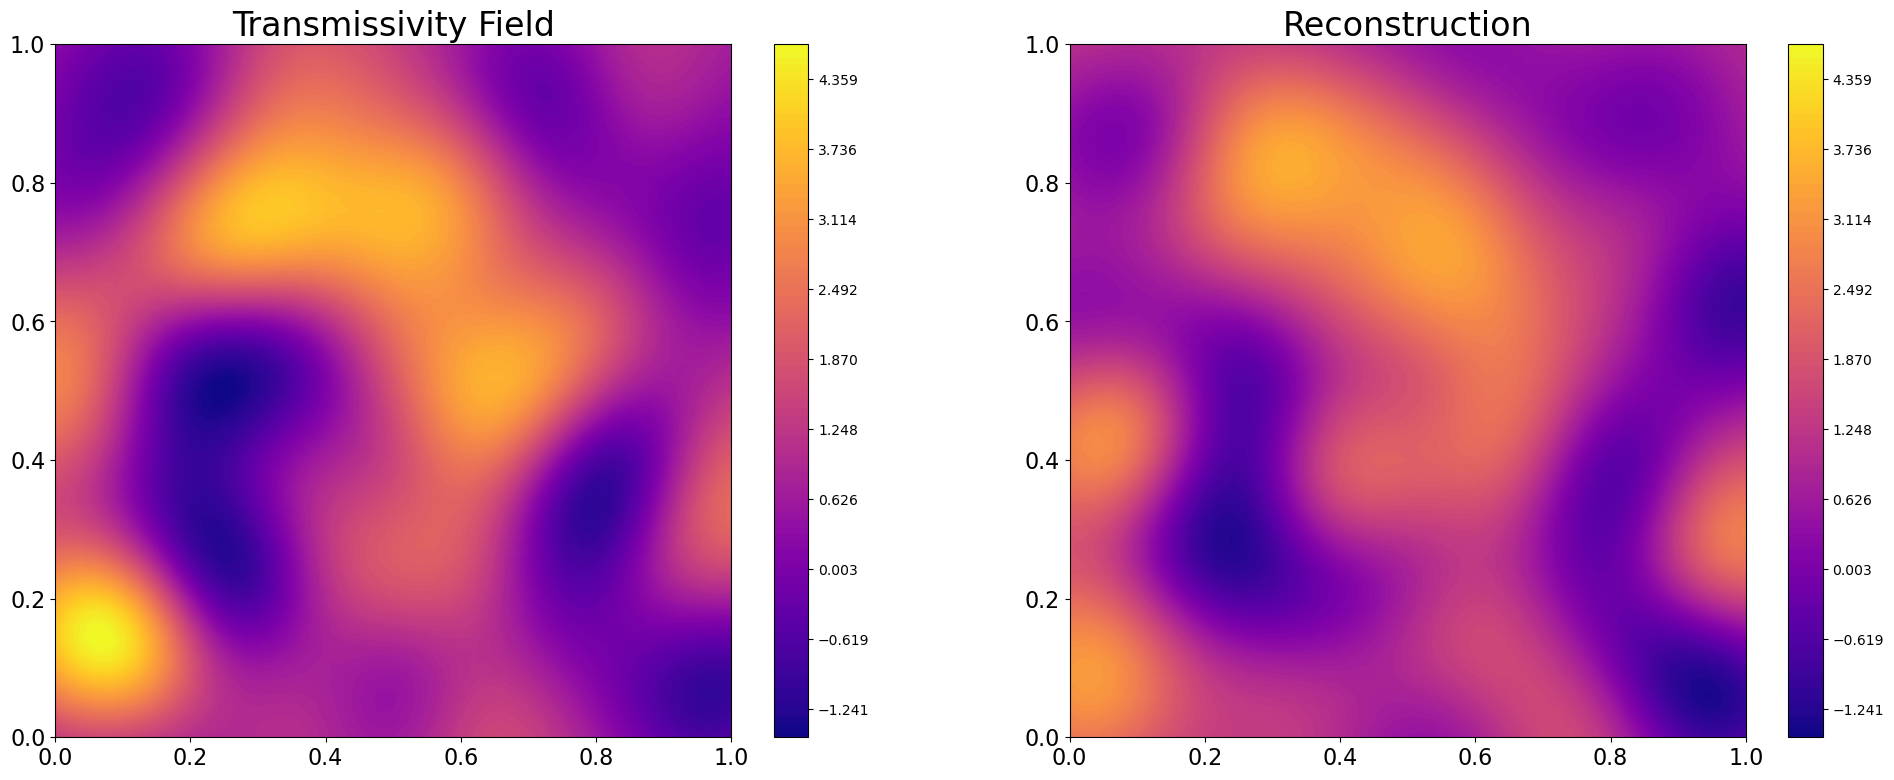

In [19]:
data = tda.get_samples(samples)['chain_0'][burnin:n_iter:thin, :]
plot_fields(x_true=x_true, x_estimated=data.mean(axis=0),n_eig=n_eig, lognormal=False) 

### No noise 

In [16]:
noise = 0.00
scaling = 0.05
n_iter =  30000 #55000
burnin = 5000 #5000
thin = 20
sub_sampling = 1


y_observed = y_true + np.random.normal(scale=noise,size=y_true.shape[0])

# LIKELYHOOD
cov_likelihood = 0.01**2 * np.eye(25)
y_distribution_coarse = tda.AdaptiveGaussianLogLike(y_observed, cov_likelihood)
y_distribution_fine  = tda.GaussianLogLike(y_observed, cov_likelihood)

# initialise the LinkFactory
my_posterior_coarse = tda.Posterior(x_distribution, y_distribution_coarse, model_lf)
my_posterior_fine = tda.Posterior(x_distribution, y_distribution_fine, model_hf)
my_posteriors = [my_posterior_coarse, my_posterior_fine]
my_proposal = tda.CrankNicolson(scaling=scaling, adaptive=False, gamma = 1.01, period=100)

# RUN THE MCMC
samples = tda.sample(my_posteriors, my_proposal, iterations=n_iter, n_chains=1, initial_parameters=np.zeros(64), subsampling_rate= sub_sampling, adaptive_error_model='state-independent')
idata = tda.to_inference_data(samples, level='fine')
# Remove the burnin and sub-sample
idata = idata.sel(draw=slice(burnin, None, thin), groups="posterior")
ess = az.ess(idata)
# Compute and print the Effective Sample Size (ESS) of the first set of samples
print("Effective Sample Size: ", ess,"\n\n\n")

Sampling chain 1/1


Running chain, α_c = 0.300, α_f = 0.15:  62%|██████▏   | 18505/30000 [01:51<01:09, 165.48it/s]


KeyboardInterrupt: 

<Figure size 1000x400 with 0 Axes>

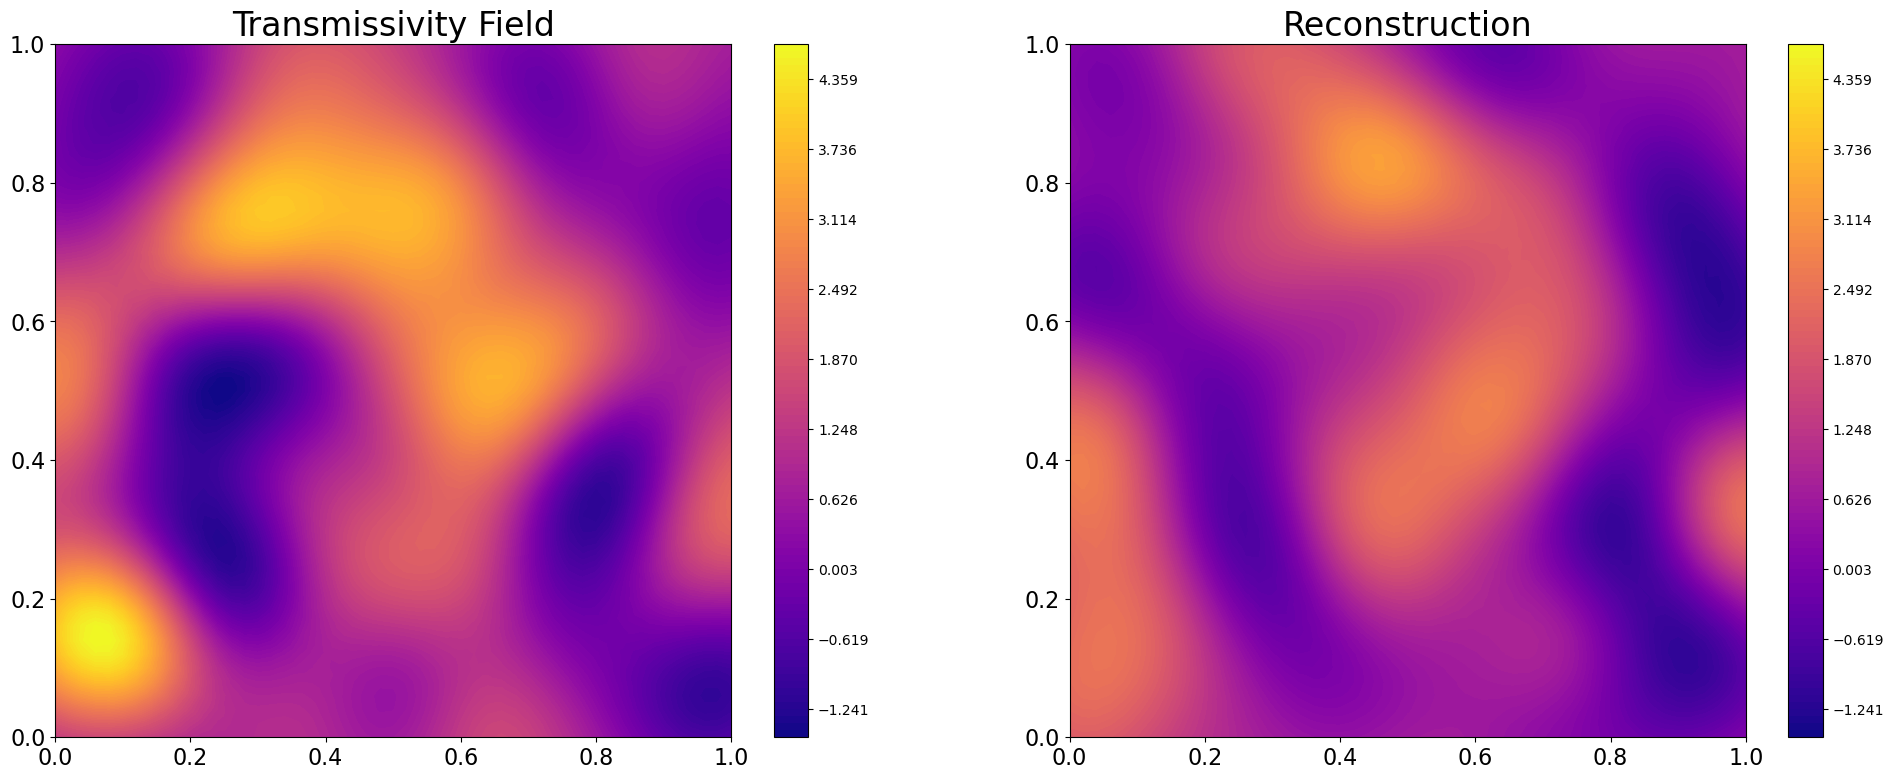

In [55]:
data = tda.get_samples(samples)['chain_0'][burnin:n_iter:thin, :]
plot_fields(x_true=x_true, x_estimated=data.mean(axis=0),n_eig=n_eig, lognormal=False) 

### True likelyhood

In [16]:
noise = 0.001
scaling = 0.007
n_iter =  30000 #55000
burnin = 5000 #5000
thin = 20
sub_sampling = 1


y_observed = y_true + np.random.normal(scale=noise,size=y_true.shape[0])

# LIKELYHOOD
cov_likelihood = noise**2 * np.eye(25)
y_distribution_coarse = tda.AdaptiveGaussianLogLike(y_observed, cov_likelihood)
y_distribution_fine  = tda.GaussianLogLike(y_observed, cov_likelihood)

# initialise the LinkFactory
my_posterior_coarse = tda.Posterior(x_distribution, y_distribution_coarse, model_lf)
my_posterior_fine = tda.Posterior(x_distribution, y_distribution_fine, model_hf)
my_posteriors = [my_posterior_coarse, my_posterior_fine]
my_proposal = tda.CrankNicolson(scaling=scaling, adaptive=False, gamma = 1.01, period=100)

# RUN THE MCMC
samples = tda.sample(my_posteriors, my_proposal, iterations=n_iter, n_chains=1, initial_parameters=np.zeros(64), subsampling_rate= sub_sampling, adaptive_error_model='state-independent')
idata = tda.to_inference_data(samples, level='fine')
# Remove the burnin and sub-sample
idata = idata.sel(draw=slice(burnin, None, thin), groups="posterior")
ess = az.ess(idata)
# Compute and print the Effective Sample Size (ESS) of the first set of samples
print("Effective Sample Size: ", ess,"\n\n\n")

Sampling chain 1/1


Running chain, α_c = 0.210, α_f = 0.10: 100%|██████████| 30000/30000 [02:47<00:00, 178.82it/s]
/Users/lucacaroselli/miniconda3/envs/fenics/lib/python3.11/site-packages/arviz/data/inference_data.py:157: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Effective Sample Size:  <xarray.Dataset> Size: 512B
Dimensions:  ()
Data variables: (12/64)
    x0       float64 8B 1.746
    x1       float64 8B 1.461
    x2       float64 8B 6.308
    x3       float64 8B 10.11
    x4       float64 8B 12.91
    x5       float64 8B 6.477
    ...       ...
    x58      float64 8B 6.043
    x59      float64 8B 1.319
    x60      float64 8B 6.161
    x61      float64 8B 6.649
    x62      float64 8B 2.452
    x63      float64 8B 1.321 





In [17]:
e = [ess.data_vars['x'+str(i)].values for i in range(64)]
np.mean(e)

3.5057760263661493

<Figure size 1000x400 with 0 Axes>

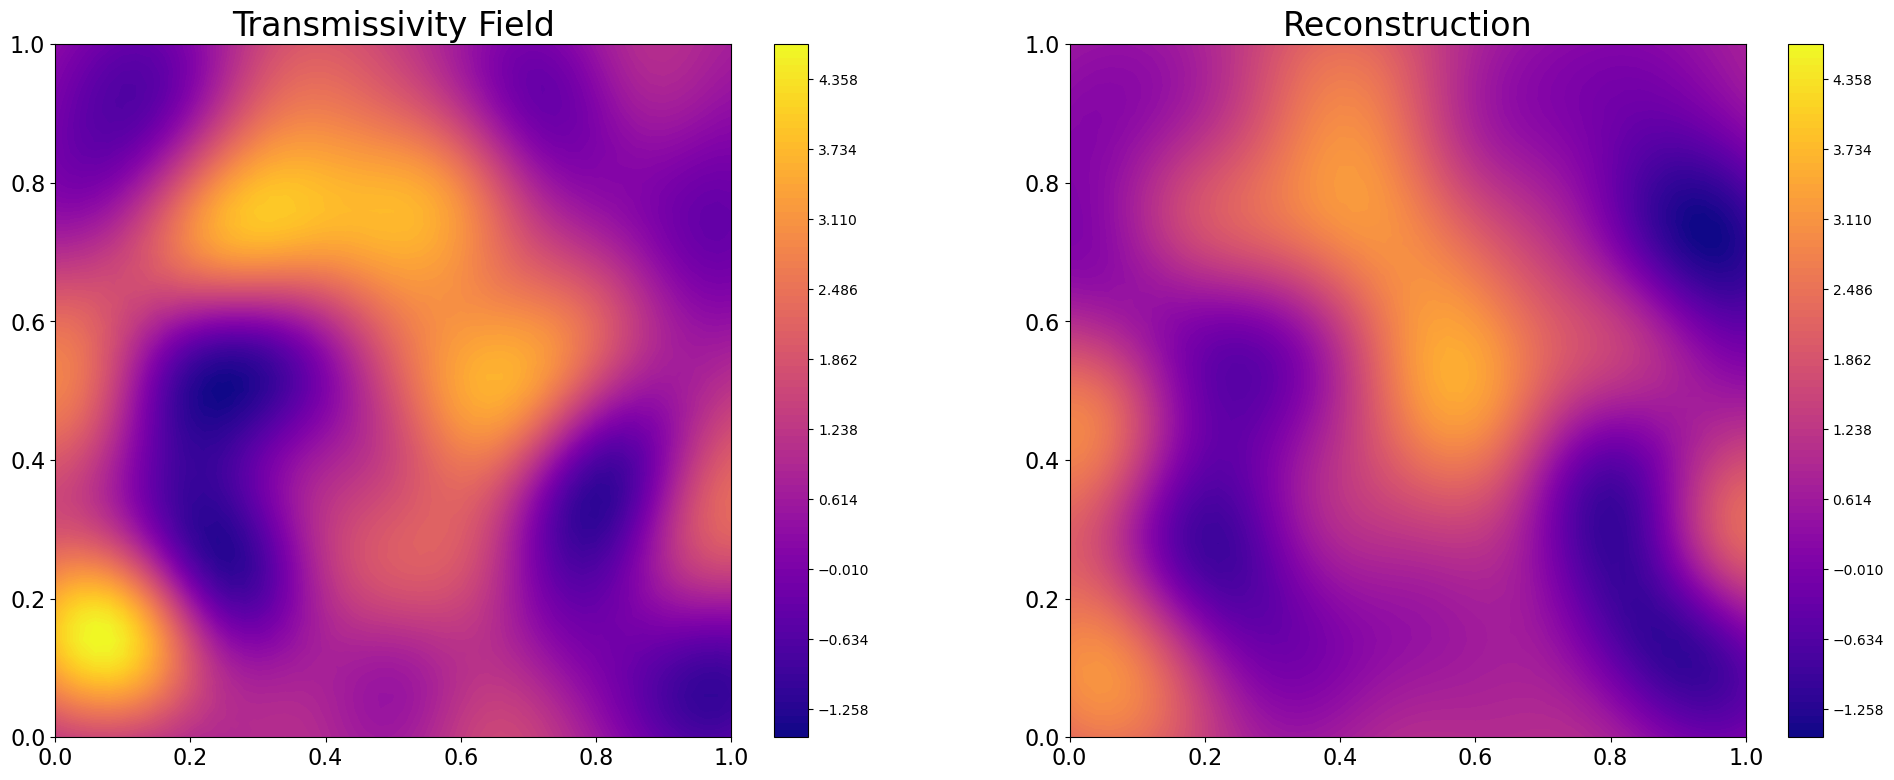

In [60]:
data = tda.get_samples(samples)['chain_0'][burnin:n_iter:thin, :]
plot_fields(x_true=x_true, x_estimated=data.mean(axis=0),n_eig=n_eig, lognormal=False) 

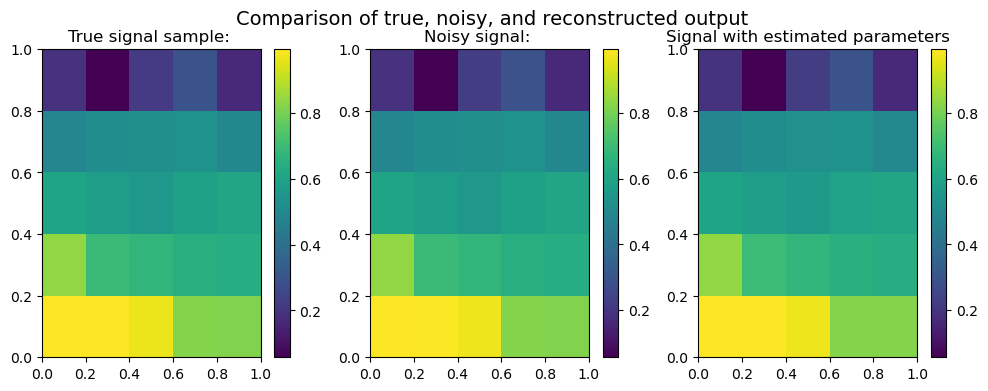

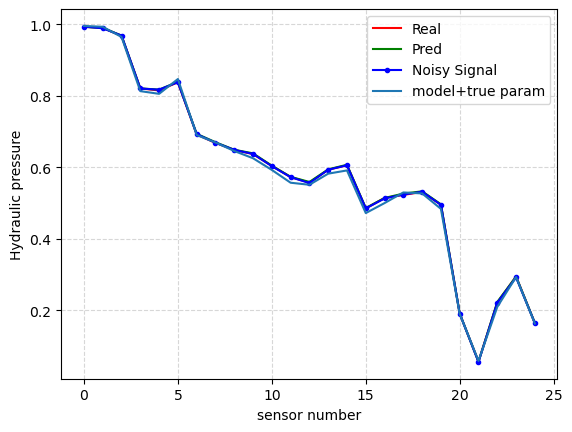

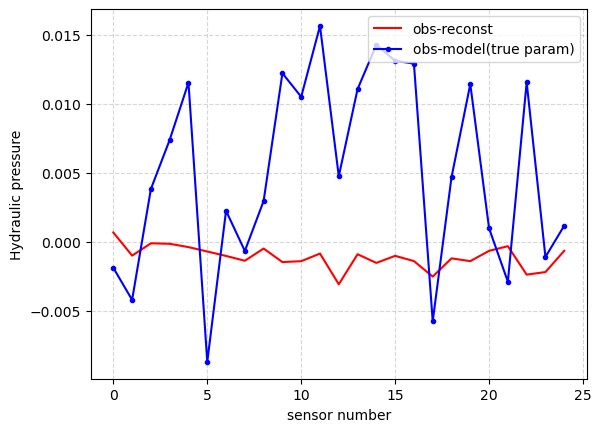

In [16]:
# Plotting and data collection
data = tda.get_samples(samples)['chain_0'][burnin:n_iter:thin, :]
plot_results( y_true, y_observed, model_nn, data, n_eig,x_true)

### Parameter tuning 

In [48]:
noise = 0.01
scaling = 0.05
n_iter =  30000 #55000
burnin = 3000 #5000
thin = 20
sub_sampling = 1


y_observed = y_true + np.random.normal(scale=noise,size=y_true.shape[0])

# LIKELYHOOD
cov_likelihood = noise**2 * np.eye(25)
y_distribution_coarse = tda.AdaptiveGaussianLogLike(y_observed, cov_likelihood)
y_distribution_fine  = tda.GaussianLogLike(y_observed, cov_likelihood)

# initialise the LinkFactory
my_posterior_coarse = tda.Posterior(x_distribution, y_distribution_coarse, model_lf)
my_posterior_fine = tda.Posterior(x_distribution, y_distribution_fine, model_hf)
my_posteriors = [my_posterior_coarse, my_posterior_fine]
my_proposal = tda.CrankNicolson(scaling=scaling, adaptive=False, gamma = 1.01, period=100)

ESS_values = []
times = []
# RUN THE MCMC
for i in range(3): 
    start = timeit.default_timer()
    samples = tda.sample(my_posteriors, my_proposal, iterations=n_iter, n_chains=1, initial_parameters=np.zeros(64), subsampling_rate= sub_sampling, adaptive_error_model='state-independent')
    end = timeit.default_timer()
    idata = tda.to_inference_data(samples, level='fine')
    # Remove the burnin and sub-sample
    idata = idata.sel(draw=slice(burnin, None, thin), groups="posterior")
    # Save executing time 
    times.append(end-start)
    ess = az.ess(idata)  
    e = [ess.data_vars['x'+str(i)].values for i in range(64)]
    ESS_values.append(np.mean(e))
# Compute and print the Effective Sample Size (ESS) of the first set of samples
print("Effective Sample Size: ", ESS_values)
print("Computing times:       ", times )
print("Average Time/ESS       ", np.mean(times)/np.mean(ESS_values))

Sampling chain 1/1


Running chain, α_c = 0.280, α_f = 0.18: 100%|██████████| 30000/30000 [02:46<00:00, 180.03it/s]
/Users/lucacaroselli/miniconda3/envs/fenics/lib/python3.11/site-packages/arviz/data/inference_data.py:157: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.240, α_f = 0.16: 100%|██████████| 30000/30000 [02:46<00:00, 180.07it/s]
/Users/lucacaroselli/miniconda3/envs/fenics/lib/python3.11/site-packages/arviz/data/inference_data.py:157: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.350, α_f = 0.27: 100%|██████████| 30000/30000 [02:45<00:00, 181.27it/s]
/Users/lucacaroselli/miniconda3/envs/fenics/lib/python3.11/site-packages/arviz/data/inference_data.py:157: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Effective Sample Size:  [8.109070508085704, 8.550349913910646, 7.62245499847879]
Computing times:        [166.8508864579926, 166.70992824999848, 165.57192595800734]
Average Time/ESS        20.555773885781328


In [18]:
noise = 0.01
scaling = 0.05
n_iter =  30000 #55000
burnin = 3000 #5000
thin = 20
sub_sampling = 2


y_observed = y_true + np.random.normal(scale=noise,size=y_true.shape[0])

# LIKELYHOOD
cov_likelihood = noise**2 * np.eye(25)
y_distribution_coarse = tda.AdaptiveGaussianLogLike(y_observed, cov_likelihood)
y_distribution_fine  = tda.GaussianLogLike(y_observed, cov_likelihood)

# initialise the LinkFactory
my_posterior_coarse = tda.Posterior(x_distribution, y_distribution_coarse, model_lf)
my_posterior_fine = tda.Posterior(x_distribution, y_distribution_fine, model_hf)
my_posteriors = [my_posterior_coarse, my_posterior_fine]
my_proposal = tda.CrankNicolson(scaling=scaling, adaptive=False, gamma = 1.01, period=100)

ESS_values = []
times = []
# RUN THE MCMC
for i in range(3): 
    start = timeit.default_timer()
    samples = tda.sample(my_posteriors, my_proposal, iterations=n_iter, n_chains=1, initial_parameters=np.zeros(64), subsampling_rate= sub_sampling, adaptive_error_model='state-independent')
    end = timeit.default_timer()
    idata = tda.to_inference_data(samples, level='fine')
    # Remove the burnin and sub-sample
    idata = idata.sel(draw=slice(burnin, None, thin), groups="posterior")
    # Save executing time 
    times.append(end-start)
    ess = az.ess(idata)  
    e = [ess.data_vars['x'+str(i)].values for i in range(64)]
    ESS_values.append(np.mean(e))
# Compute and print the Effective Sample Size (ESS) of the first set of samples
print("Effective Sample Size: ", ESS_values)
print("Computing times:       ", times )
print("Average Time/ESS       ", np.mean(times)/np.mean(ESS_values))

Sampling chain 1/1


Running chain, α_c = 0.400, α_f = 0.19:  52%|█████▏    | 15454/30000 [03:40<03:27, 70.06it/s] 


KeyboardInterrupt: 